# 🐶 Dog Breed Classification 

This notebook builds an end-to-end multi-class image classifier using TenserFlow 2.0 and TenserFlow Hub

We're going to take the following approach:
1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation


## 1. Problem Definition
> Identifying the breed of a dog given image of a dog.

## 2. Data
The data came from Kaggle's [dog breed indentification competiton.](https://www.kaggle.com/c/dog-breed-identification/data)

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed for each test image.
[Kaggle](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation)

## 4. Features
Some information about the data:
[Kaggle](https://www.kaggle.com/c/dog-breed-identification/data)

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in training set (these images have labels).
* There are around 10,000+ images in test set(these images have no labels, because we'll want to predict them).


In [0]:
# Unzip the uploaded data to google drive
#!unzip '/content/drive/My Drive/Dog Breed Classification/dog-breed-identification.zip' -d '/content/drive/My Drive/Dog Breed Classification/'

## Preparing the tools

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using GPU

In [0]:
# Import TensorFlow into Colab
# import tensorflow as tf
# print('TF version: ',tf.__version__)

In [0]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in colab
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version: ',tf.__version__)
print('TF Hub version: ',hub.__version__)

# Check for GPU availability
print('GPU : Available' if tf.config.list_physical_devices('GPU') else 'GPU : Not Available')

TF version:  2.2.0-rc1
TF Hub version:  0.7.0
GPU : Available


 Tensors is just a fancy word for matrix aka numpy array

# Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format.

Let's start by accessing our data and checking out thr labels.

In [5]:
# Checkout the labels of our data
import pandas as pd

labels = pd.read_csv('/content/drive/My Drive/Dog Breed Classification/labels.csv')
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [6]:
labels.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     b422718878d017e73752b3765d0c361b  scottish_deerhound
freq                                   1                 126

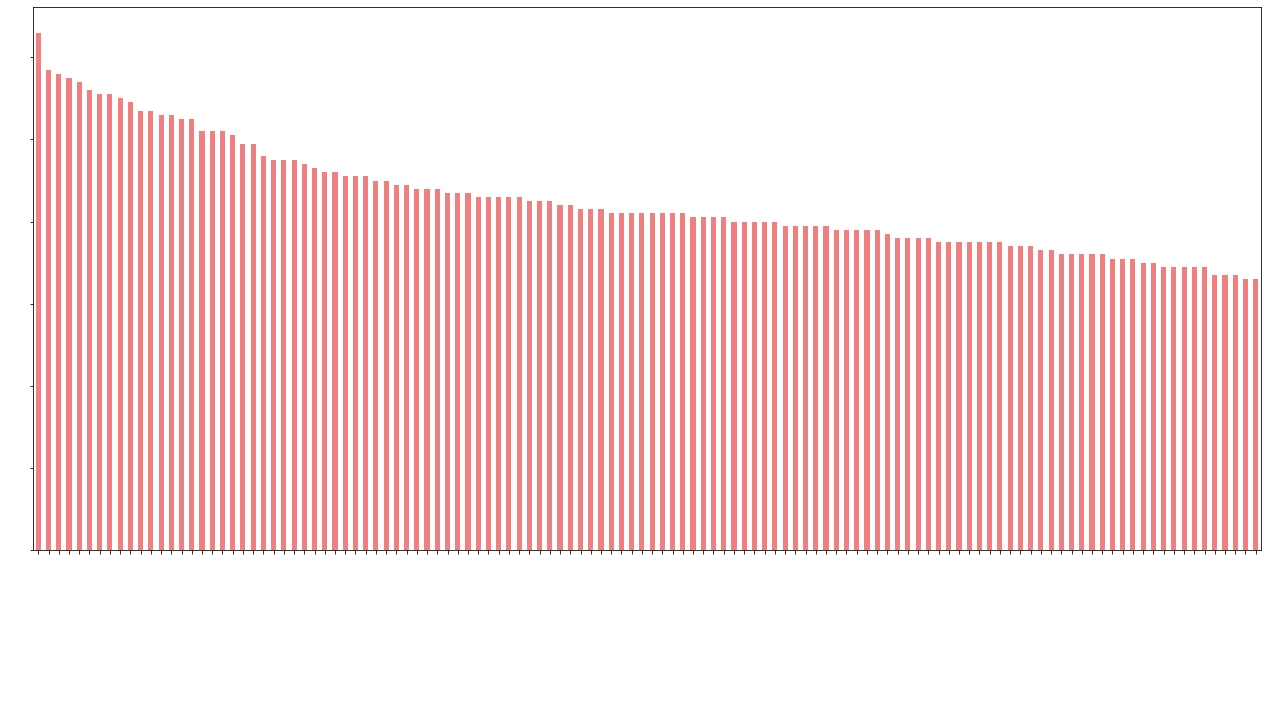

In [7]:
# How many images are there of each breed
import matplotlib.pyplot as plt

labels['breed'].value_counts().plot.bar(figsize=(22,10),color='lightcoral');

# Because i'm using Dark Theme
plt.xticks(color='white');
plt.yticks(color='white');

In [8]:
labels['breed'].value_counts().median()

82.0

As per the Google documentation,
There should be atleast 10 images per class, But 100 images per class is better. 

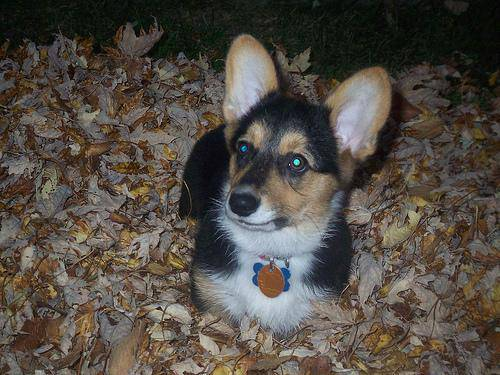

In [9]:
# Let's view an image
from IPython.display import Image
Image('drive/My Drive/Dog Breed Classification/train/def67b643b92ee3d6cdec1128df0a9b6.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [10]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
# Create pathnames from image ID's

filenames = ['drive/My Drive/Dog Breed Classification/train/'+fname + '.jpg' for fname in labels['id']]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Breed Classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Breed Classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Breed Classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Breed Classification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Breed Classification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Breed Classification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Breed Classification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Breed Classification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Breed Classification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Breed Classification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether number of filenames matches number of actual image file
import os
# os.lisdir() -> it will go in the directory & list all the files in directory
if len(os.listdir('drive/My Drive/Dog Breed Classification/train/'))==len(filenames):
  print('Filenames match actual amount of files!! Proceed')
else:
  print('Filenames do not match actual amount of files, check the traget directory')

Filenames match actual amount of files!! Proceed


In [13]:
os.listdir('drive/My Drive/Dog Breed Classification/train/')[:5]

['f48ebf5f79e746455810091b884e8eb8.jpg',
 'f6e186742c1885a3c4a66396195d8a18.jpg',
 'f60ad1508afefc6ce94cd896ff1cdb3f.jpg',
 'f3f01549c30b4d1ae3e6701b729ab080.jpg',
 'f40a0d368a62d9e2d2fb2d7583368538.jpg']

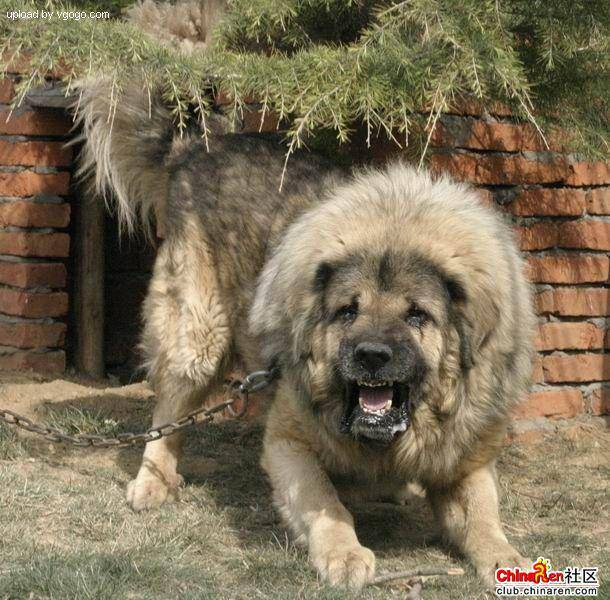

In [14]:
Image(filenames[9000])

In [15]:
labels['breed'][9000]

'tibetan_mastiff'

Since we've now got training image filepaths in a list, Let's prepare our labels

In [16]:
import numpy as np
labels_breed = labels['breed']
labels_breed = np.array(labels_breed)
labels_breed

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
len(labels_breed)

10222

In [18]:
# See if number of labels matches the number of filenames
if len(labels_breed) == len(filenames):
  print('Number of labels matchs number of filenames!')
else:
  print('Number of labels does not match number of filenames, check data directories')

Number of labels matchs number of filenames!


In [19]:
# Find the unique labels
unique_breeds = np.unique(labels_breed)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [20]:
len(labels_breed)

10222

In [21]:
# Turn a single label into an array of booleans
labels_breed[0] == np.unique(labels_breed)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into boolean array
boolean_labels = [breed == unique_breeds for breed in labels_breed]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Example : Turning boolean array into integers
print(labels_breed[0]) # original label
print(np.where(unique_breeds == labels_breed[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where sample labels occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
# Example : Turning boolean array into integers
print(labels_breed[1]) # original label
print(np.where(unique_breeds == labels_breed[1])) # index where label occurs
print(boolean_labels[1].argmax()) # index where label occurs in boolean array
print(boolean_labels[1].astype(int)) # there will be a 1 where sample labels occurs

dingo
(array([37]),)
37
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating Our Own Validation Set

Since the dataset from Kaggle doesn't come with validation set we are going to create our own.

In [0]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [27]:
len(filenames), len(boolean_labels)

(10222, 10222)

We're going to start of experimenting with ~1000 images and increase as needed.

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000}

In [29]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [30]:
# Let's have a gaze at the training data
X_train[:2], y_train[:2]

(['drive/My Drive/Dog Breed Classification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Breed Classification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, F

## Preprocessing Images (turning images into Tensors)

To preprocess our images into tensors we're going to write a function which does a few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` ( convert color channel values from 0-255 to 0-1 )
4. Resize the `image` to be shape of (224, 224)
5. Return the modefied `image`

Before we do, let's see what importing an image looks like

In [31]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [32]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [33]:
image.min(), image.max()

(0, 255)

In [34]:
# Turn image into Tensors
tf.constant(image) # 257 rows, 350 arrays inside each row, and ech array cotains 3 columns 

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensors , lets make a functiion to process them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be shape of (224, 224) H x W
5. Return the modefied `image`

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  '''
  Takes the image file path and turns the image into Tensors
  '''

  # Read in image file
  image = tf.io.read_file(image_path)

  # Turn the jpg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to desired value (224, 2224) square
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  # return the image
  return image

In [36]:
# Reading the image file
tensor = tf.io.read_file(filenames[0])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [37]:
# Converting image file image file to numerical tensors
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[107,  45,   0],
        [151,  91,  41],
        [177, 119,  69],
        ...,
        [175, 143,  68],
        [189, 157,  82],
        [213, 181, 106]],

       [[150,  92,  46],
        [179, 121,  75],
        [164, 110,  63],
        ...,
        [167, 136,  56],
        [171, 140,  60],
        [187, 156,  76]],

       [[150,  97,  55],
        [187, 136,  93],
        [161, 112,  69],
        ...,
        [199, 168,  78],
        [193, 162,  72],
        [200, 169,  79]],

       ...,

       [[188, 121,  66],
        [185, 118,  63],
        [182, 117,  63],
        ...,
        [213, 160, 106],
        [211, 158, 104],
        [208, 155, 101]],

       [[185, 118,  63],
        [183, 116,  61],
        [182, 117,  63],
        ...,
        [196, 144,  86],
        [199, 147,  90],
        [199, 147,  89]],

       [[181, 114,  59],
        [181, 114,  59],
        [181, 116,  62],
        ...,
        [184, 132,  7

In [38]:
# Converting from 0-255 to 0-1 makes our computing effcient
# It's called normalization
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.41960788, 0.1764706 , 0.        ],
        [0.5921569 , 0.35686275, 0.16078432],
        [0.69411767, 0.4666667 , 0.27058825],
        ...,
        [0.6862745 , 0.56078434, 0.26666668],
        [0.7411765 , 0.6156863 , 0.32156864],
        [0.8352942 , 0.70980394, 0.4156863 ]],

       [[0.5882353 , 0.36078432, 0.18039216],
        [0.7019608 , 0.47450984, 0.29411766],
        [0.6431373 , 0.43137258, 0.24705884],
        ...,
        [0.654902  , 0.53333336, 0.21960786],
        [0.67058825, 0.54901963, 0.23529413],
        [0.73333335, 0.6117647 , 0.29803923]],

       [[0.5882353 , 0.3803922 , 0.21568629],
        [0.73333335, 0.53333336, 0.3647059 ],
        [0.6313726 , 0.43921572, 0.27058825],
        ...,
        [0.7803922 , 0.65882355, 0.30588236],
        [0.7568628 , 0.63529414, 0.28235295],
        [0.7843138 , 0.6627451 , 0.30980393]],

       ...,

       [[0.7372549 , 0.47450984, 0.25882354],
        [0.72

In [39]:
process_image(X[42])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

Batch - Small portion of your data, 32 is a default batch size with most of the 
machine learning model

## Turning our data into batches

Why turn our data into batches?

Let's say your trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust the batch size if needed)

In order to use TensorFlow effectively we need our data in the form of Tensor tuple which look like this
`(image, label)`.

In [0]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  '''
  Takes an image file path and the associated label,
  proccess the image and returns a tuple of (image, label)
  '''
  image = process_image(image_path)

  return image, label

In [41]:
# Demo of the above
get_image_label(tf.constant(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [0]:
# Define the batch size i.e. 32
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Create batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  '''
  # tf.constant - Creates a constant tensor from a tensor-like object.

  # If the data is test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # this says, pass me some Tensors and I'll create dataset out of that
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE) # process the image and turn it into the batch
    return data_batch

  else:
    print('Creating training data batches....')
    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image processor function us faster than shuffling
    data = data.shuffle(buffer_size=len(X))

    # Creates (image, label) tuples (this also turns the image path into a preprocessed image)
    # And turn the training data into batches
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  return data_batch



In [43]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches....
Creating validation data batches...


In [44]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Exploring Above Function

In [45]:
# Filepaths
X[:5]

['drive/My Drive/Dog Breed Classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Breed Classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Breed Classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Breed Classification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Breed Classification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [46]:
# Converting filepaths into constant Tensor to perform the operations
data = tf.constant(X)
data

<tf.Tensor: shape=(10222,), dtype=string, numpy=
array([b'drive/My Drive/Dog Breed Classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
       b'drive/My Drive/Dog Breed Classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
       b'drive/My Drive/Dog Breed Classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
       ...,
       b'drive/My Drive/Dog Breed Classification/train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg',
       b'drive/My Drive/Dog Breed Classification/train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg',
       b'drive/My Drive/Dog Breed Classification/train/fff43b07992508bc822f33d8ffd902ae.jpg'],
      dtype=object)>

In [47]:
# type & length

len(data), type(data)

(10222, tensorflow.python.framework.ops.EagerTensor)

In [48]:
# Creating dataset -> pass filepaths and labels in the form of Tensor constants
tensor_data_set = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                      tf.constant(y)))
tensor_data_set

<TensorSliceDataset shapes: ((), (120,)), types: (tf.string, tf.bool)>

In [49]:
# Creates (image, label) tuples (this also turns the image path into a preprocessed image)
# This also turns the tensor_data_set into bathes

tensor_image_label = tensor_data_set.map(get_image_label)
tensor_image_label

<MapDataset shapes: ((224, 224, 3), (120,)), types: (tf.float32, tf.bool)>

In [50]:
tensor_batches = tensor_image_label.batch(BATCH_SIZE)
tensor_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend let's visualize them.

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in data batch

def show_25_images(images, labels):
  '''
  Displays a plot of 25 images and their labels from a data batch
  '''

  # Setup the figure 
  plt.figure(figsize=(10,10))

  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots ( 5 rows, 5 columns )
    ax = plt.subplot(5, 5, i+1) # 5 rows 5 columns and index

    # Display image
    plt.imshow(images[i])

    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()], color='white')

    # Turn the grid lines off
    plt.axis('off')
    

In [52]:
# next() -> Returns next item from iterator
# the below function is gonna take our batch dataset, it's gonna unwind it from batch and turn it into numpy iterator
# next() is going to grab the first batch off the top of this out of this iterator
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[1.20141536e-01, 1.46314234e-01, 9.67207272e-03],
          [1.35029882e-01, 1.65789679e-01, 3.04597300e-02],
          [1.60871848e-01, 1.98459402e-01, 6.51348084e-02],
          ...,
          [9.62030172e-01, 9.85559583e-01, 9.77716446e-01],
          [9.50132668e-01, 9.73662078e-01, 9.65818942e-01],
          [9.38427806e-01, 9.61957216e-01, 9.54114079e-01]],
 
         [[1.31869853e-01, 1.80469304e-01, 1.55183179e-02],
          [1.57709390e-01, 2.13469192e-01, 5.05665243e-02],
          [1.88720852e-01, 2.49868169e-01, 9.10533816e-02],
          ...,
          [9.49526846e-01, 9.73056257e-01, 9.65213120e-01],
          [9.57342863e-01, 9.80872273e-01, 9.73029137e-01],
          [9.49702322e-01, 9.73231733e-01, 9.65388596e-01]],
 
         [[2.51013517e-01, 3.33575159e-01, 1.30660236e-01],
          [2.62218267e-01, 3.55026990e-01, 1.48531884e-01],
          [2.53873169e-01, 3.54713500e-01, 1.49925321e-01],
          ...,
          [9.15643454e-01, 9.39172864e-01, 9.3132

In [53]:
# First batch
len(train_images), len(train_labels)

(32, 32)

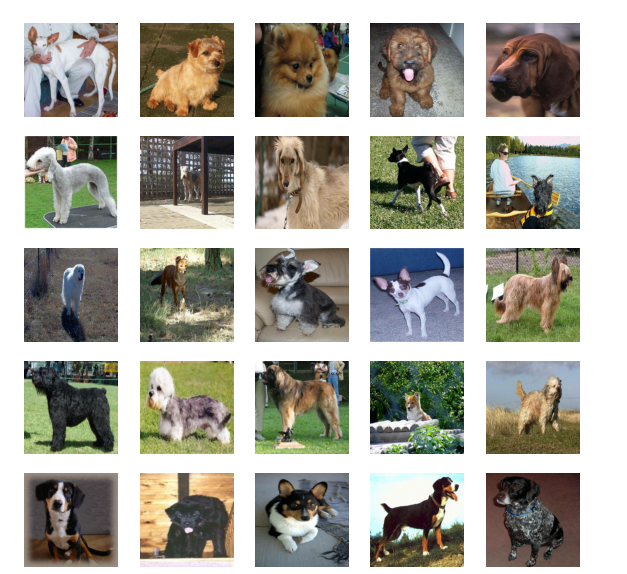

In [54]:
# Now let's visualize the data in training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

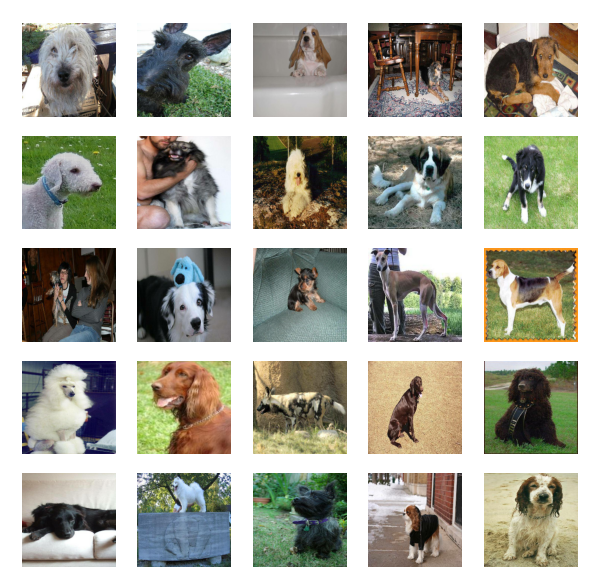

In [55]:
# Now let's visualize for validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are few things we need to define
* The input shape ( our images shape, in the form of Tensors ) of our model.
* The output shape ( image labels, in the form of Tensors ) of our model.
* The URL of the model we want to use from [TensorFlow Hub](https://tfhub.dev/s?module-type=image-classification).

In [56]:
IMG_SIZE

224

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now we've got out inputs, output and model ready to go let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Define the layers in a Keras model in  sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells the model input shape it will be getting).
* Returns the model

All of this steps can be found [here](https://www.tensorflow.org/guide/keras/overview)

Keras - This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality

In [0]:
# Create a function which builds a Keras model

# we are using image size 224, 224 bcoz that is the size that mobilnet model trained on

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url= MODEL_URL):
  print('Building model with: ',model_url)

  # Setup the model layers / Instatiated model
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # Layer 1 (input layer) It's telling TensorFlow hub to create keras layer of model_url
      tf.keras.layers.Dense(units=output_shape, # 120 patterns
                            activation='softmax') # Layer 2 output layer
  ])

# softmax - converts the patterns between 0-1
# If we work with binary classification the activation function is "Sigmoid"



  # Compile the model
  model.compile(
      # loss is measure of how well the model is guessing, the higher the loss worse the prediction.
      # lower the loss the better is model is leanrning the patterns
      loss = tf.keras.losses.CategoricalCrossentropy(), # for binary classification use BinaryCrossentropy()

      # Optimizer - tells how model can improved their gueses witch each epoch
      optimizer = tf.keras.optimizers.Adam(),
      
      # Metric - how well our model is predicting the correct labels
      metrics = ['accuracy']
  )

  # Build the model
  model.build(input_shape)

  return model


In [59]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper function a model can use during training to do such things as save it's progress, check it's progress or stop training early if model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping
which prevents our model from training for too long.

### TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it our model `fit()` function
3. Visualize our model's training logs with `%tensorboard` magic function (we'll do this after model training)


In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('/content/drive/My Drive/Dog Breed Classification/logs',
                # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%Y/%m/%d-%H:%M:%S'))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callbacks

Now let's create an early stopping callback early stopping helps prevent overfitting.
If a model trains for too long it can actually do so well at finding patterns in a certain dataset that it's not able to use those patterns on a nother data set. So it doesn't generalize well.


**Example:** 


If you were to learn the course materials far too well you learnt them off by heart a.k.a. if you're in university and you've studied way too hard on the course materials you've memorized them off by heart.


So When it come to a practice exam or a final exam with questions that you haven't seen before and you memorized everything on course materials instead of just learning the inherent problem solving patterns of the course materials you're not going to do very well on the practice exam or the final exam.

In [0]:
# Create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure  everything is working.

In [0]:
# number of epochs is how many passes of the data.
# pass is you can imagine is equivalent to our model trying to find patterns in each dog image
# and see which patterns relate to each label.
NUM_EPOCHS = 100 #@param {type: 'slider', min: 10, max: 100, step:10}

one epoch would be giving our model a single chance to look at all the training data and then validating it from their.


100 epochs means we're giving our model up to 100 chances to go through the training dataset and figure out the patterns.


In [64]:
# Check to make sure we're still running on GPU
print('GPU: Available' if tf.config.list_physical_devices('GPU') else 'GPU: Not Available')

GPU: Available


# Let's create a function which trains a model

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensor_board()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we we'd like to use
* Return the model

In [0]:
# Build a function train and return trained model
def train_model():
  '''
  Trains a given model and returns the trained version
  '''

  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callback we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # return the fitted model
  return model

In [66]:
# # Fit the model to data
# model = train_model()
model_path='drive/My Drive/Dog Breed Classification/models/20200329-14581585493887_1000-images-mobilenetV2.h5'
model = tf.keras.models.load_model(model_path,
                                     custom_objects={
                                         'KerasLayer':hub.KerasLayer
                                     })

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?


**Note:** Overfitting to begin with is a good thing! It means our model is learning

### Checking the TesnorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.


In [67]:
%tensorboard --logdir /content/drive/My\ Drive/Dog\ Breed\ Classification/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and avaluating predictions using a trained model

In [68]:
# Make predictions on validation data (not used to train on)

predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 71s 10s/step


array([[1.54985592e-03, 3.08607297e-04, 5.19945286e-04, ...,
        2.38132561e-04, 1.77797028e-05, 6.14374236e-04],
       [1.49283733e-03, 5.03475312e-04, 9.20423865e-03, ...,
        9.85717750e-04, 3.29205533e-03, 3.39004997e-04],
       [3.34909623e-06, 1.86824225e-04, 2.65737890e-05, ...,
        4.01482612e-05, 1.44325095e-05, 1.87639729e-04],
       ...,
       [2.88201386e-06, 1.06145497e-04, 6.49827780e-05, ...,
        2.62668364e-05, 1.76748857e-04, 6.17544210e-05],
       [2.59910361e-03, 1.60124968e-04, 1.99040383e-04, ...,
        1.00820769e-04, 3.86337888e-05, 5.55667514e-03],
       [2.24721269e-03, 1.28299735e-05, 3.17136641e-04, ...,
        1.73860427e-03, 4.60900017e-04, 3.03280412e-05]], dtype=float32)

In [69]:
predictions.shape # 200 rows, 120 columns in each row

(200, 120)

In [70]:
len(predictions[0]), len(predictions[1])

(120, 120)

In [71]:
# First predictions
index = 42
print(predictions[0])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

[1.5498559e-03 3.0860730e-04 5.1994529e-04 3.4771350e-05 1.2437122e-04
 2.5527628e-05 1.0596879e-02 2.4384493e-04 3.2690060e-04 2.9829971e-04
 1.9606615e-03 5.4569366e-05 3.9414124e-04 5.9823771e-05 8.2510919e-04
 7.8059507e-05 1.1603004e-04 2.2021857e-01 1.0127700e-05 3.3730164e-05
 8.5556239e-04 6.7606987e-04 3.8618389e-05 3.3225745e-04 5.0236569e-05
 2.3525431e-04 1.0185474e-01 4.1675373e-04 1.2436145e-03 2.9781504e-04
 7.9791076e-05 1.2007583e-02 1.0115128e-03 2.5164551e-05 8.4978965e-05
 1.4439063e-02 7.2048671e-05 5.0337090e-05 3.9857339e-05 3.1262793e-05
 6.8182149e-04 1.6000184e-05 1.2756867e-04 4.7553731e-05 4.2954336e-05
 7.3072733e-05 7.6739052e-06 1.8765459e-04 2.9416342e-04 5.0282752e-04
 3.1598250e-04 7.8449222e-05 8.0123084e-04 5.3578908e-05 1.7976431e-04
 1.4691754e-05 4.3654261e-04 2.5994913e-03 2.3675658e-04 1.0392096e-01
 5.6694512e-04 4.0906867e-05 6.4847700e-04 1.6476093e-05 5.9558754e-04
 1.5520684e-02 1.9346279e-04 2.9714606e-04 2.4638170e-02 1.1803204e-04
 1.674

Having the above functionality is great but we want to be able to do it at scale. 


And it would be even better if we could see the image prediction is being made on!

**Note:** Predictions probability are also known as confidence levels.

In [72]:
# Turn probability into their respective label (easier to understand)

def get_pred_label(prediction_probability):
  '''
  Turns an array of predictions probabilities into label
  '''
  return unique_breeds[np.argmax(prediction_probability)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [73]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [74]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

images_[0], labels_[0]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [75]:
# Create a function to unbatch dataset
def unbatchify(batch_dataset):
  '''
  Takes a batch dataset of (image, label) Tesnors and returns sepearte arrays
  of images and labels
  '''
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in batch_dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels


# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [76]:
get_pred_label(val_labels[0])

'affenpinscher'

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualize.

We'll create a function which: 
* Take an array of prediction probabilities, an array of truth labels and an array of images and integers
* Convert the prediction probabilities to predicted label.
* Plot the predicted label, it's predicted probability, the truth label and target image on a single plot.


In [0]:
def plot_preds(prediction_probabilities, labels, images, n=1):
  '''
  View the prediciton, ground truth and image for sample n
  '''
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color='green'
  else:
    color='red'


  # Change plot title to be predicted, probability of predictions and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
             color=color)
  

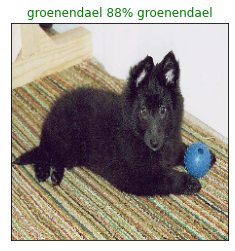

In [78]:
plot_preds(prediction_probabilities=predictions,
           labels=val_labels,
           images=val_images,
           n=77
           )

Now we've got one function to visualize our model's top prediction, let's make another to view our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array and ground truth array and integers
* Find the predicted label using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels

* Plot the top 10 prediction probability values and labels, coloring the true label green.



In [0]:
def plot_pred_top_10(prediction_probabilities, labels, n=1):
  ''''
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  '''
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidences indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels,
              rotation='vertical',
              color='white')

  plt.yticks(color='white')

  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass
  

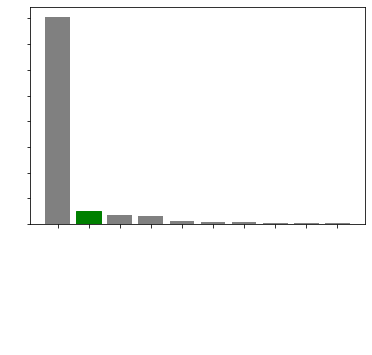

In [80]:
plot_pred_top_10(prediction_probabilities=predictions,
                labels=val_labels,
                n=9)

In [81]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.22021857, 0.16740121, 0.10392096, 0.10185474, 0.0893494 ,
       0.07202583, 0.03950493, 0.02463817, 0.01844894, 0.01552068],
      dtype=float32)

In [82]:
predictions[0].argsort()[-10:][::-1]

array([ 17,  70,  59,  26, 102, 103,  73,  68, 106,  65])

In [83]:
predictions[0].argsort()

array([ 46,  18,  55,  41,  63, 118, 108,  86,  33,   5,  75,  72,  39,
        19,   3, 112,  22,  38,  99,  61,  84,  44,  43,  92, 107,  24,
        37, 115,  53,  11,  13,  36, 113,  45,  15,  51,  30,  34,  82,
        16,  69,  71,   4, 101,  42,  95, 114,  54,  47, 104,  66,  94,
        80,  25,  58, 117,   7,  88,  48,  67,  29,   9,   1, 111,  50,
         8,  23,  78,  12,  89, 105,  27,  56,  91, 110,  49,  87,   2,
        96,  85,  60,  64, 119,  62,  21,  40,  52,  14,  20,  32,  28,
        98,   0,  10,  90,  57,  76,  83,  74, 116,  79,  77,  93, 100,
        81,   6,  31,  35,  97, 109,  65, 106,  68,  73, 103, 102,  26,
        59,  70,  17])

In [84]:
unique_breeds[predictions[0].argsort()[-10:][::-1]]

array(['border_terrier', 'lhasa', 'irish_wolfhound', 'cairn',
       'silky_terrier', 'soft-coated_wheaten_terrier', 'maltese_dog',
       'lakeland_terrier', 'standard_schnauzer', 'komondor'], dtype=object)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

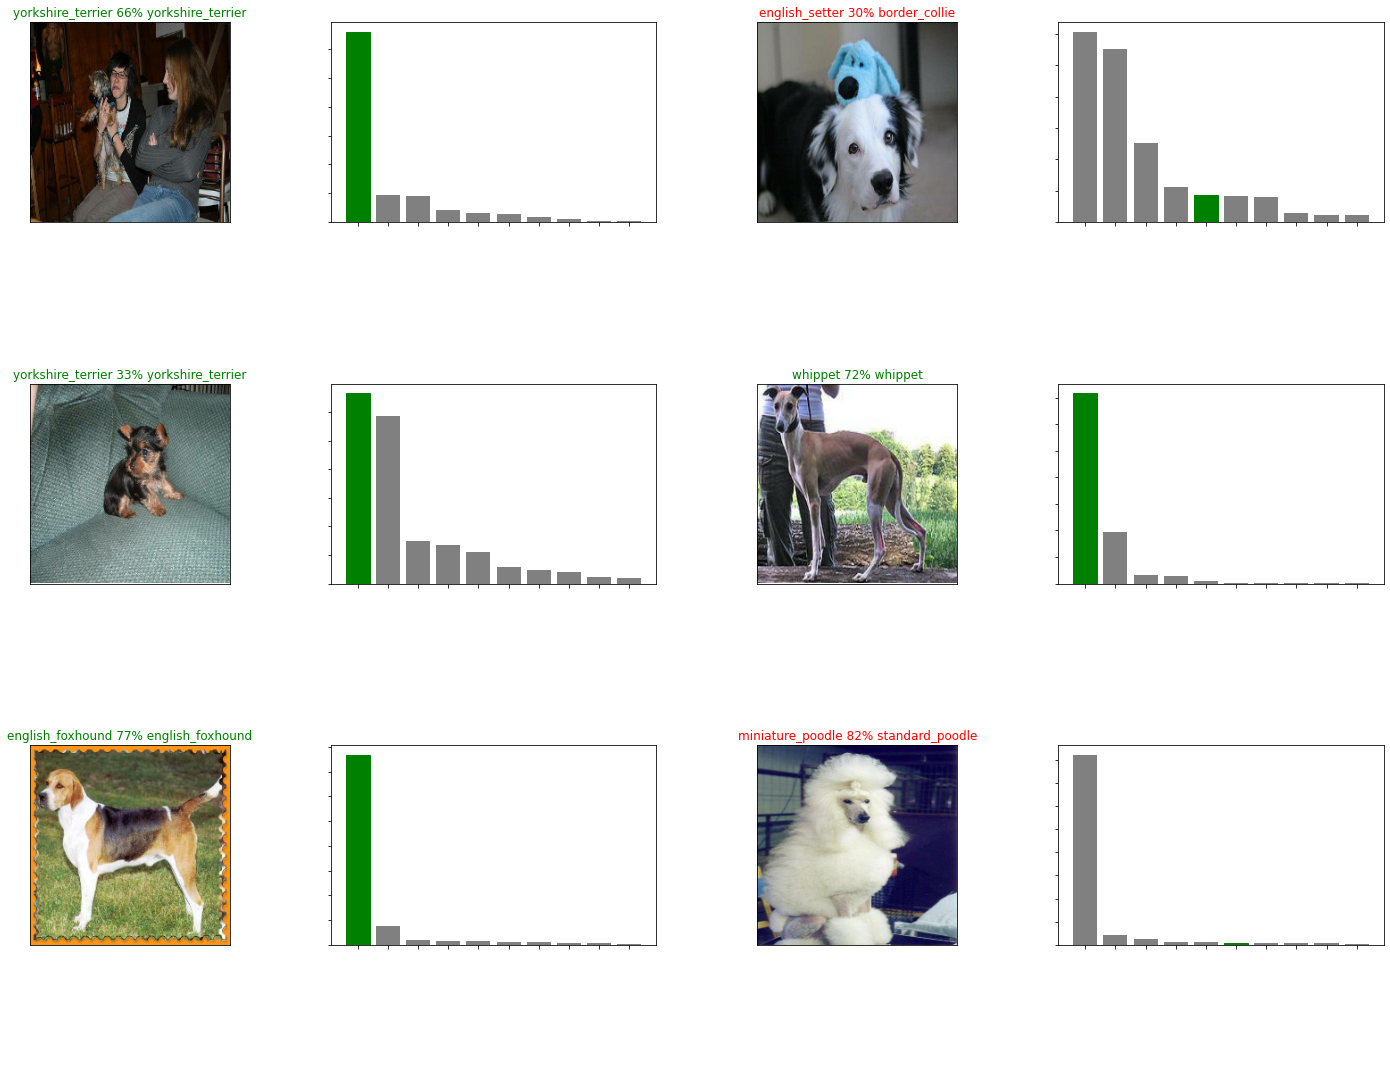

In [85]:
# Let's checkout few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_image = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_image):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_preds(prediction_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_top_10(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
  
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model


In [0]:
# Create a function to save a model

def save_model(model, suffix=None):
  '''
  Saves a given model in a models directory and appends a suffix (string)
  '''

  # Create a model directory pathname with current time
  modeldir = os.path.join('drive/My Drive/Dog Breed Classification/models/',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  
  model_path = modeldir + '_' + suffix + '.h5' # save format of model
  print(f'Saving model to: {model_path}...')
  model.save(model_path)

  return model_path



In [0]:
# Creates a function to load a trained model

def load_model(model_path):
  '''
  Loads a saved model from specified path.
  '''
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={
                                         'KerasLayer':hub.KerasLayer
                                     })
  return model

Now we've got functions to save and load trained model, let's make sure they work!


In [88]:
# Save our model trained on 1000 images
save_model(model, suffix='1000-images-mobilenetV2')

Saving model to: drive/My Drive/Dog Breed Classification/models/20200330-08211585556487_1000-images-mobilenetV2.h5...


'drive/My Drive/Dog Breed Classification/models/20200330-08211585556487_1000-images-mobilenetV2.h5'

In [89]:
# Load trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Breed Classification/models/20200329-14581585493887_1000-images-mobilenetV2.h5')


Loading saved model from: drive/My Drive/Dog Breed Classification/models/20200329-14581585493887_1000-images-mobilenetV2.h5


In [90]:
# Evaluate the pre-saved model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 143ms/step - loss: 1.1789 - accuracy: 0.6800


[1.1789286136627197, 0.6800000071525574]

## Training a model on the full data

In [91]:
len(X), len(y)

(10222, 10222)

In [92]:
X[:10]

['drive/My Drive/Dog Breed Classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Breed Classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Breed Classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Breed Classification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Breed Classification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Breed Classification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Breed Classification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Breed Classification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Breed Classification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Breed Classification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [93]:
len(X_train)

800

In [94]:
y[:1]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False])]

In [95]:
# Create a databatch with full data set
full_data = create_data_batches(X,y)

Creating training data batches....


In [96]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [97]:
# Create a model for full model
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)


**Note:** Runnung the cell below will take  a little while (may be up to 30 minutes for the first epoch because we're using in the runtime has to load all of the images into memmory.)

In [0]:
# # Fit the full model to the full data
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [0]:
save_model(full_model, suffix='full-image-mobilenetV2')

In [101]:
# Loading the full model
load_full_model = load_model('drive/My Drive/Dog Breed Classification/models/20200329-18451585507501_full-image-mobilenetV2.h5')


Loading saved model from: drive/My Drive/Dog Breed Classification/models/20200329-18451585507501_full-image-mobilenetV2.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()`earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have the labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.






In [103]:
# Load test image filename
test_path = '/content/drive/My Drive/Dog Breed Classification/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog Breed Classification/test/f27521a58ff23d0bb6390bd802b368c4.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ea4a775ecbf81b2cd2967cc34ce4e52b.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/f37106dba00385993428e7c557b15805.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ed0ec7befaa38726a118ab7e4d53b332.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ed3b2e79859710376b7a91379234b1ec.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/eb278b7573e08beb43823a006a7ba690.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ef58b740df67a98d390f5bf8513bcea5.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/eb9f2db3d5204c85c26daeb7669b20a3.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/f1c1f35ca91cd9d007f957da29aa087e.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/f24c3d9735880ef6ea736dc549419771.jpg']

In [104]:
len(test_filenames)

10357

In [105]:
# Create test data batch
test_data = create_data_batches(test_filenames,test_data=True)

Creating test data batches...


In [106]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr)

In [107]:
# Make predictions on test data batch using the loaded full model
test_predictions = load_full_model.predict(test_data,
                                             verbose=1)
# 10357 / 32 (batch size) = 324

324/324 [==============================] - 4932s 15s/step


In [108]:
# Save predictions (NumPy array) to csv file (for access later)
type(test_predictions)

numpy.ndarray

In [0]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt('/content/drive/My Drive/Dog Breed Classification/preds_array.csv', test_predictions, delimiter=',')

In [0]:
# Load predicitions (NumPy array) from csv file
test_predictions = np.loadtxt('/content/drive/My Drive/Dog Breed Classification/preds_array.csv', delimiter=',')

In [115]:
test_predictions[10356][:120] 

array([4.15588144e-14, 2.93668108e-07, 1.24294661e-12, 2.81491740e-11,
       4.40555849e-13, 7.63788338e-12, 4.61322083e-12, 4.08743785e-12,
       5.36894913e-06, 3.18453389e-11, 4.82090989e-09, 1.34013477e-11,
       9.00099051e-10, 2.73757978e-11, 9.99994040e-01, 2.51746135e-09,
       5.80840877e-13, 2.34876745e-12, 1.85221435e-12, 5.10469217e-13,
       9.58905468e-14, 1.01868449e-12, 5.86268672e-11, 5.84660931e-10,
       3.31620446e-13, 8.52786841e-10, 5.12345244e-12, 1.54509896e-13,
       2.08277795e-09, 1.27622305e-13, 3.37663196e-11, 1.05034232e-07,
       5.84550008e-08, 1.59538216e-11, 1.94322683e-12, 3.81286391e-11,
       3.19181431e-10, 1.04418245e-10, 4.45545250e-12, 4.93468599e-10,
       1.78066711e-11, 1.65123404e-09, 5.27237594e-11, 4.35754124e-12,
       9.42537172e-13, 5.89092178e-11, 4.67983291e-11, 2.26866106e-13,
       7.86211304e-11, 2.37990179e-08, 4.52986226e-09, 5.60003866e-09,
       5.45254286e-09, 8.47457955e-12, 1.83220640e-13, 2.76327971e-11,
      

In [112]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for kaggle

Looking at the [Kaggle](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation) sample solution, we find that it wants our models prediction probability outputs in DataFrame with an ID and a column for each different dog breed.

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.


In [116]:
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [117]:
test_filenames[:5]

['/content/drive/My Drive/Dog Breed Classification/test/f27521a58ff23d0bb6390bd802b368c4.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ea4a775ecbf81b2cd2967cc34ce4e52b.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/f37106dba00385993428e7c557b15805.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ed0ec7befaa38726a118ab7e4d53b332.jpg',
 '/content/drive/My Drive/Dog Breed Classification/test/ed3b2e79859710376b7a91379234b1ec.jpg']

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [124]:
test_ids[:5]

['f27521a58ff23d0bb6390bd802b368c4',
 'ea4a775ecbf81b2cd2967cc34ce4e52b',
 'f37106dba00385993428e7c557b15805',
 'ed0ec7befaa38726a118ab7e4d53b332',
 'ed3b2e79859710376b7a91379234b1ec']

In [0]:
preds_df['id'] = test_ids

In [126]:
preds_df.head()

id  ... yorkshire_terrier
0  f27521a58ff23d0bb6390bd802b368c4  ...               NaN
1  ea4a775ecbf81b2cd2967cc34ce4e52b  ...               NaN
2  f37106dba00385993428e7c557b15805  ...               NaN
3  ed0ec7befaa38726a118ab7e4d53b332  ...               NaN
4  ed3b2e79859710376b7a91379234b1ec  ...               NaN

[5 rows x 121 columns]

In [0]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [128]:
preds_df.head()

id  ... yorkshire_terrier
0  f27521a58ff23d0bb6390bd802b368c4  ...       8.56408e-10
1  ea4a775ecbf81b2cd2967cc34ce4e52b  ...       7.47721e-09
2  f37106dba00385993428e7c557b15805  ...        4.0163e-09
3  ed0ec7befaa38726a118ab7e4d53b332  ...       4.31218e-09
4  ed3b2e79859710376b7a91379234b1ec  ...       2.15202e-12

[5 rows x 121 columns]

In [0]:
# Save our predictions dataset to csv for submission to Kaggle
preds_df.to_csv('/content/drive/My Drive/Dog Breed Classification/full-model-submission-1-mobilenetV2.csv',
                index=False)

## Making predictions on custom images, we'll:

* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* compare the predicted labels to the custom images



In [0]:
# Get the custom image filepaths

custom_path = '/content/drive/My Drive/Dog Breed Classification/dog-photos/'
custom_images_paths = [custom_path + fname for fname in os.listdir(custom_path)]


In [131]:
custom_images_paths

['/content/drive/My Drive/Dog Breed Classification/dog-photos/labrador.jpg',
 '/content/drive/My Drive/Dog Breed Classification/dog-photos/labrador2.jpg',
 '/content/drive/My Drive/Dog Breed Classification/dog-photos/aus-shepherd-husky.jpg',
 '/content/drive/My Drive/Dog Breed Classification/dog-photos/golden-retriever.jpg']

In [133]:
# Turn the custom images into batch datasets
custom_data = create_data_batches(custom_images_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [134]:
# Make predictions on the custom data
custom_preds = load_full_model.predict(custom_data)
custom_preds

array([[2.47869253e-10, 1.72832582e-09, 2.74772805e-09, 2.90788744e-08,
        5.71906269e-01, 3.62585502e-06, 8.57260218e-08, 5.91360516e-09,
        5.28582348e-07, 2.13485946e-05, 3.10145225e-08, 3.07958020e-10,
        1.90596313e-06, 3.26213190e-08, 1.26488160e-07, 1.01341129e-06,
        7.54403331e-08, 2.59947903e-08, 1.46996044e-07, 8.27442150e-08,
        4.30614128e-10, 5.90648490e-08, 9.21128729e-10, 2.01560027e-07,
        8.59085674e-07, 8.11999143e-06, 1.42814494e-09, 2.37950388e-08,
        3.11326330e-05, 1.30715492e-08, 5.60732905e-10, 7.40614541e-06,
        1.14767863e-06, 1.44345563e-06, 6.16303595e-08, 1.51701424e-05,
        1.01078777e-10, 1.35462193e-08, 6.11419637e-07, 1.55139560e-06,
        2.92877103e-05, 5.63898766e-07, 8.71297967e-09, 2.59607380e-09,
        1.73248300e-05, 2.04759698e-09, 5.22089216e-08, 1.49108544e-07,
        1.56172518e-05, 1.26500010e-01, 1.62287427e-06, 7.47090951e-03,
        1.49992604e-06, 6.19078419e-05, 5.41947198e-09, 1.385709

In [136]:
custom_preds.shape

(4, 120)

In [0]:
# Get custom image predictions labels
custom_pred_labels =[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [138]:
custom_pred_labels

['american_staffordshire_terrier',
 'labrador_retriever',
 'siberian_husky',
 'golden_retriever']

In [0]:
# Get custom images (our unbatchify function won't work since there aren't labels...maybe we could fix this later)
custom_images = []

# Loop through unbacthed data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)


In [140]:
# Check custom image predictions
custom_images

[array([[[0.9215687 , 0.9176471 , 0.93725497],
         [0.91316533, 0.90924376, 0.9288516 ],
         [0.85616255, 0.852241  , 0.8718488 ],
         ...,
         [0.39485067, 0.32034084, 0.29288986],
         [0.49175128, 0.41331992, 0.41486135],
         [0.5846992 , 0.5023463 , 0.5376404 ]],
 
        [[0.9215687 , 0.9176471 , 0.93725497],
         [0.91915834, 0.9152368 , 0.9348446 ],
         [0.8673495 , 0.86342794, 0.8830358 ],
         ...,
         [0.38271305, 0.30820322, 0.28075224],
         [0.46338996, 0.38495857, 0.3865    ],
         [0.545763  , 0.46341014, 0.49870425]],
 
        [[0.9215687 , 0.9176471 , 0.93725497],
         [0.9236695 , 0.91974795, 0.9393558 ],
         [0.8757704 , 0.8718488 , 0.89145666],
         ...,
         [0.37349284, 0.29898304, 0.27153206],
         [0.41822675, 0.33979535, 0.3413368 ],
         [0.46206534, 0.3797124 , 0.41500652]],
 
        ...,
 
        [[0.75052816, 0.76447153, 0.58254033],
         [0.73601407, 0.77912503, 0.60053

In [144]:
len(custom_images)

4

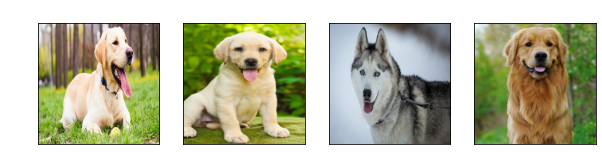

In [146]:
# Check custom predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i],color='white')
  plt.imshow(image)
